<a href="https://colab.research.google.com/github/prashantmalan/NSE/blob/main/Another_copy_of_Isolation_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# prompt: how to mount drive to read csv

from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
dff = pd.read_csv('/content/drive/My Drive/Colab Notebooks/anomaly/Pm_CFTC_2017649.csv')
col_cat=pd.read_csv("/content/drive/My Drive/Colab Notebooks/anomaly/col_cat_5.csv")
dff = dff[~dff.applymap(lambda x: ';' in str(x)).any(axis=1)]
dff.reset_index(drop=True, inplace=True)
dff = dff.applymap(lambda x: str(x).replace(',', '') if isinstance(x, str) else x)
dff = dff.applymap(lambda x: str(x).replace('+', '') if isinstance(x, str) else x)
dff = dff[~dff.applymap(lambda x: ';' in str(x)).any(axis=1)]

for column in dff.columns:
    dff[column + '_dtype'] = dff[column].dtypes
    dff[column + '_d_length'] = dff[column].apply(lambda x: len(str(x)))
    dff[column + '_d_isnull'] = dff[column].isnull()





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import IsolationForest
# Convert date columns to numeric
df=dff.copy()
datetime_columns=col_cat[col_cat['Type']=='DateTime']['Column']
for column in datetime_columns:
    df[column] = pd.to_datetime(df[column], errors='coerce').astype('int64') // 10**9
    print(column)

date_columns=col_cat[col_cat['Type']=='Date']['Column']
#date_columns = df.select_dtypes(include=['datetime']).columns
for column in date_columns:
    df[column] = pd.to_datetime(df[column], errors='coerce').astype('int64') // 10**9
    #print(column)

cat_columns=col_cat[col_cat['Type']=='Cat']['Column']
#date_columns = df.select_dtypes(include=['datetime']).columns
label_encoders = {}
for column in cat_columns:
    df[column].fillna('MISSING')
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])
    label_encoders[column] = {index: label for index, label in enumerate(label_encoders[column].classes_)}





In [ ]:
features = df.select_dtypes(include=['number']).columns.tolist()

features = [col for col in features if '_dtype' not in col and '_d_length' not in col and '_d_isnull' not in col]

# Split data into features and target (if you have a target variable)
X = df[features]

# Scale the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean') # You can change the strategy if needed
X_scaled = imputer.fit_transform(X_scaled)

# Train an Isolation Forest model
model = IsolationForest(contamination=0.05)  # Adjust contamination as needed
model.fit(X_scaled)


# Predict anomalies
predictions = model.predict(X_scaled)

# Add predictions to the DataFrame
df['anomaly_prediction'] = predictions
dff['anomaly_prediction'] = predictions





In [ ]:
dff['anomaly_prediction'].value_counts()

,count
anomaly_prediction,
1,8103
-1,427


In [ ]:
# prompt: can I see the reason of anamoly prediction, a bit more detail how this records  ends up in anomaly

# Get the anomaly scores
anomaly_scores = model.decision_function(X_scaled)

# Add anomaly scores to the DataFrame
df['anomaly_score'] = anomaly_scores

# Sort the DataFrame by anomaly score in descending order
df_sorted = df.sort_values(by='anomaly_score', ascending=True)

# Display the top 10 records with the highest anomaly scores
print(dff[dff['anomaly_prediction'] == -1])
# You can also analyze the features that contribute most to the anomaly score
# For example, you can look at the values of the features for the anomalous records
# and compare them to the distribution of the features in the normal data.


      Dissemination Identifier  Original Dissemination Identifier Action type  \
155                  935753358                                NaN        NEWT   
156                  935753359                                NaN        NEWT   
158                  935753361                                NaN        NEWT   
159                  935753362                        934196863.0        MODI   
160                  935753363                        834345292.0        MODI   
...                        ...                                ...         ...   
8451                 933472003                        855870196.0        MODI   
8480                 933472010                        855870587.0        MODI   
8483                 933472016                        468324217.0        MODI   
8485                 933472019                        855870484.0        MODI   
8520                 933472347                        468312384.0        MODI   

     Event type Amendment i

In [ ]:
model.estimators_[1]

ExtraTreeRegressor(max_depth=8, max_features=1, random_state=701055591)

       Dissemination Identifier  Original Dissemination Identifier  \
count              4.270000e+02                       2.440000e+02   
mean               9.339991e+08                       8.003678e+08   
std                8.895677e+05                       1.928220e+08   
min                9.313105e+08                       3.077640e+08   
25%                9.334987e+08                       6.507957e+08   
50%                9.337923e+08                       9.324518e+08   
75%                9.341531e+08                       9.337003e+08   
max                9.357534e+08                       9.355787e+08   

       Quantity frequency multiplier-Leg 1  \
count                                338.0   
mean                                   1.0   
std                                    0.0   
min                                    1.0   
25%                                    1.0   
50%                                    1.0   
75%                                    1.0   
m

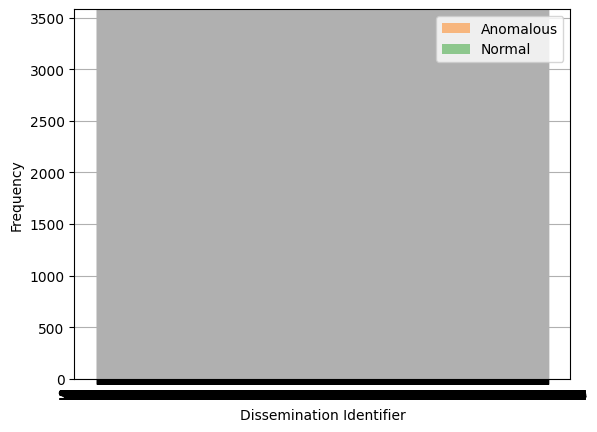

Original Dissemination Identifier


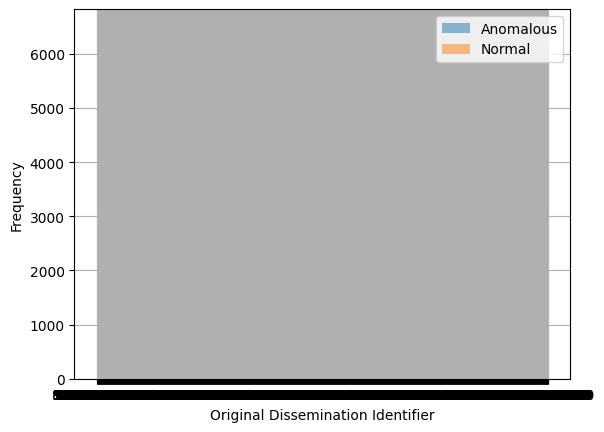

Action type


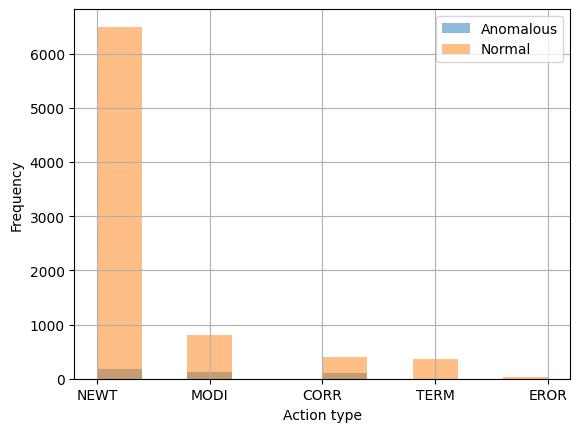

Event type


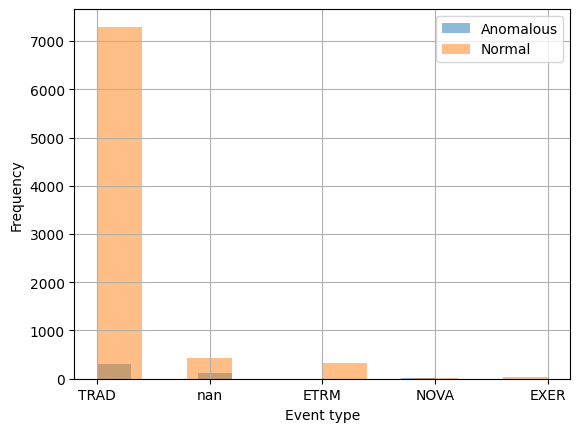

Amendment indicator


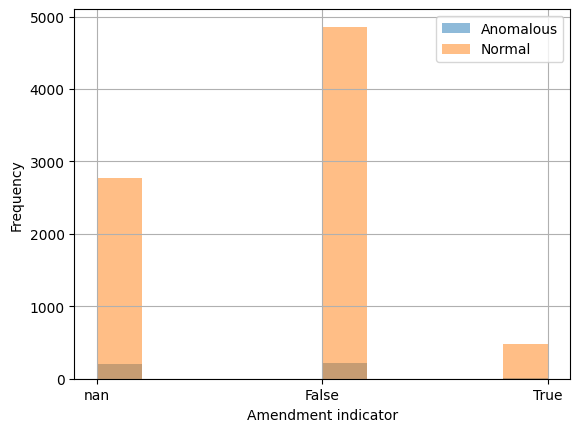

Asset Class


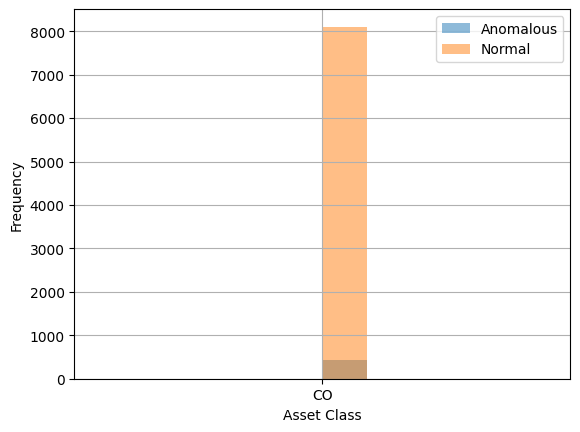

Product name


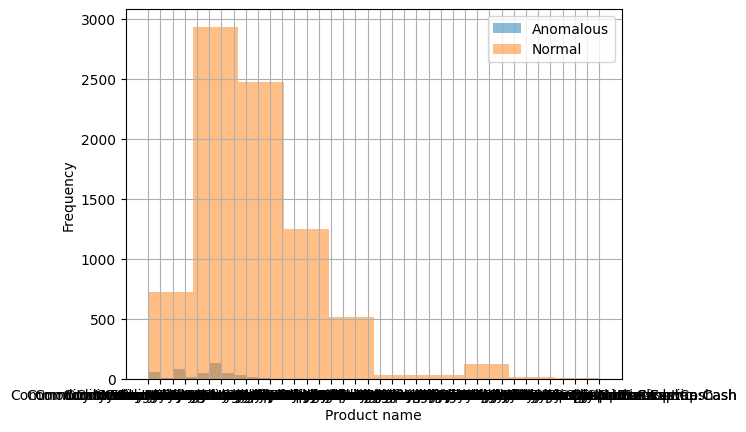

Cleared


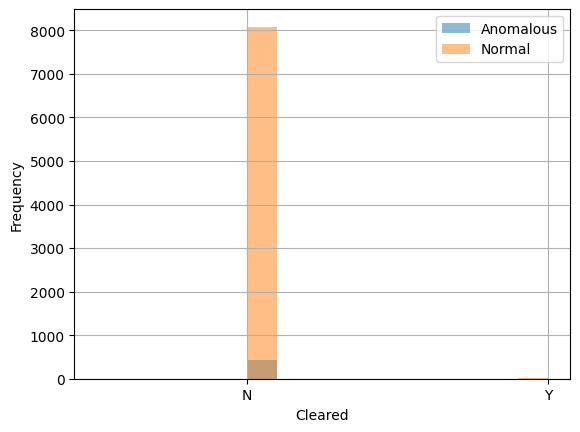

Mandatory clearing indicator


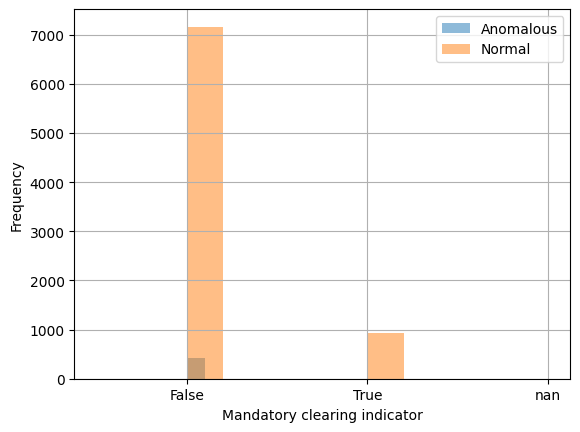

Execution Timestamp


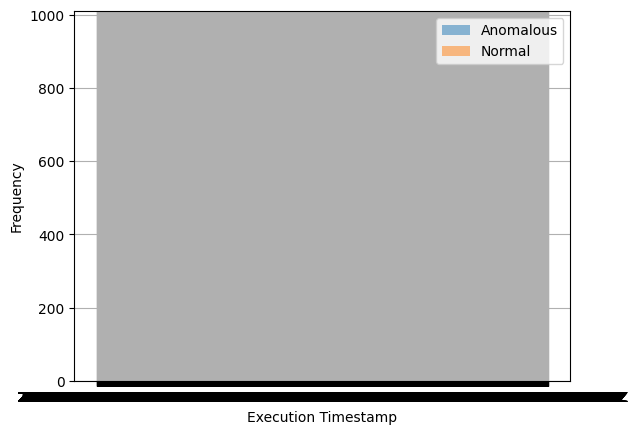

Effective Date


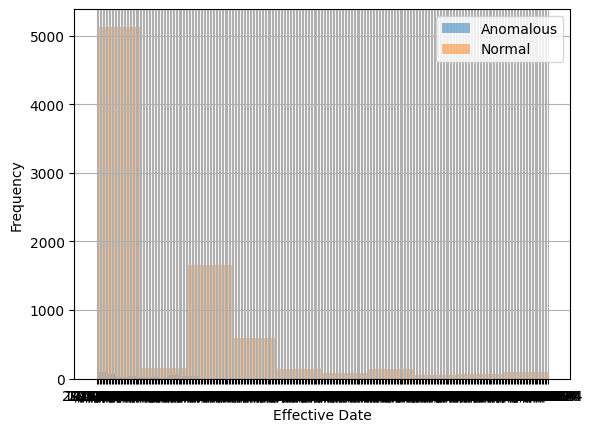

Expiration Date


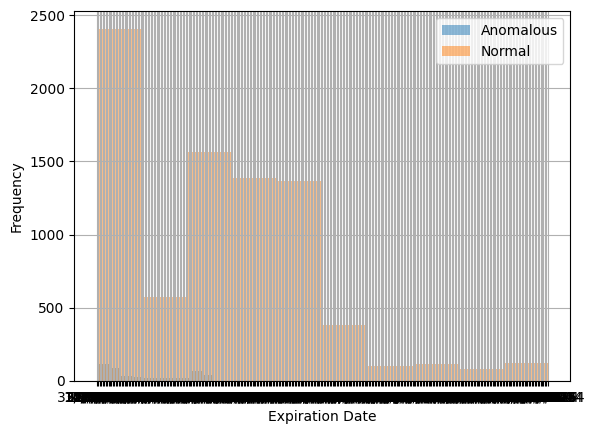

Maturity date of the underlier


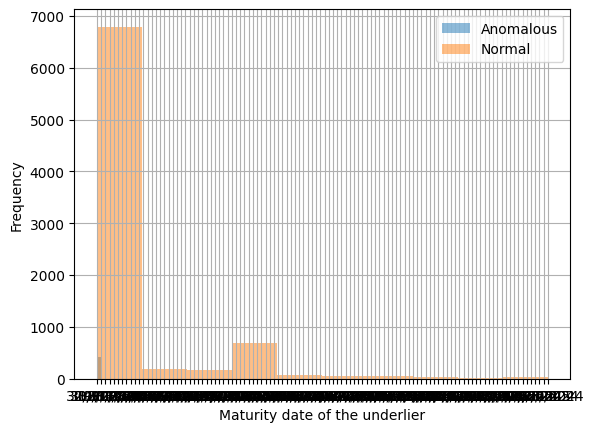

Skipping boolean feature: Non-standardized term indicator
Platform identifier


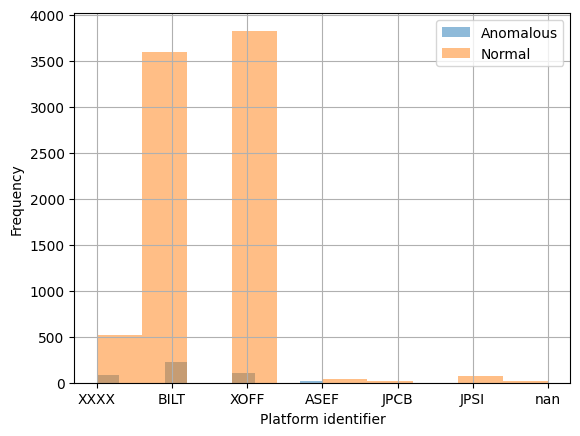

Prime brokerage transaction indicator


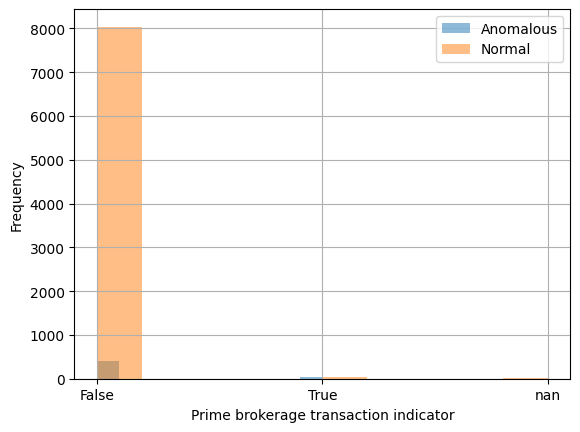

Block trade election indicator


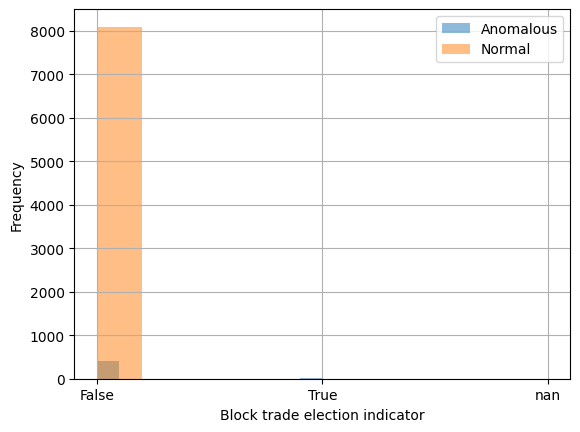

Large notional off-facility swap election indicator


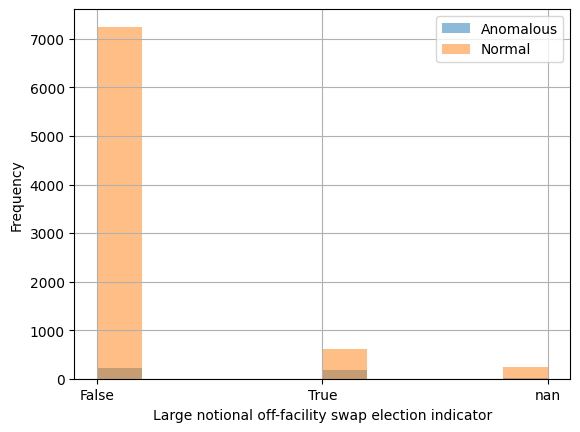

Notional currency-Leg 1


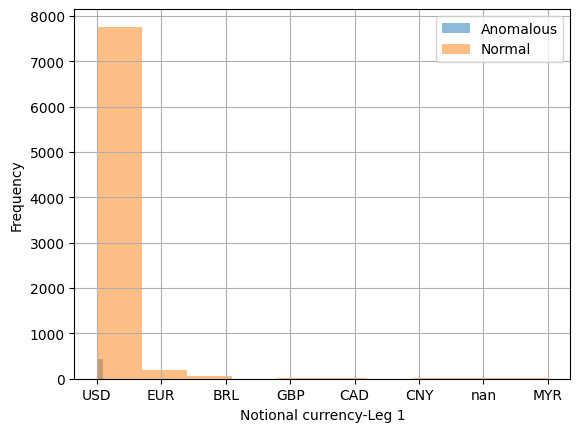

Notional currency-Leg 2


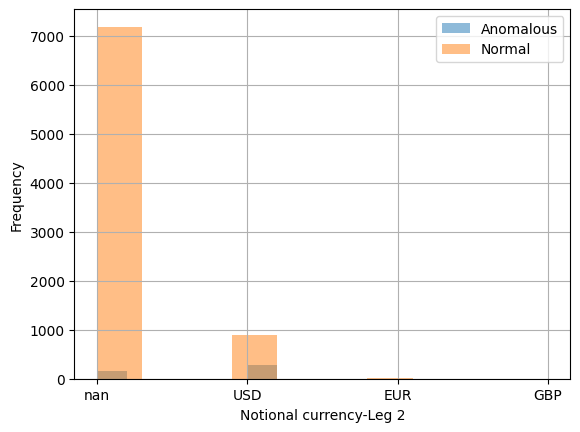

Quantity frequency multiplier-Leg 1


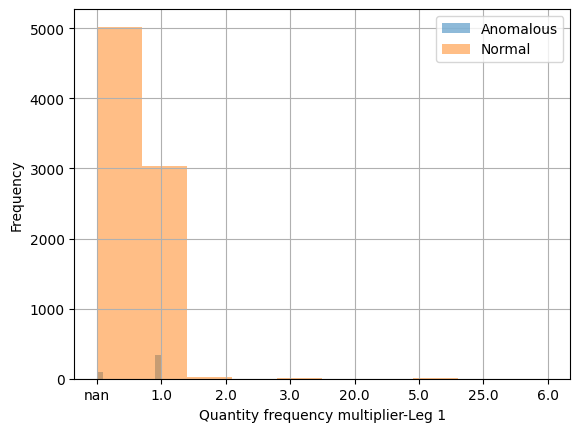

Quantity frequency multiplier-Leg 2


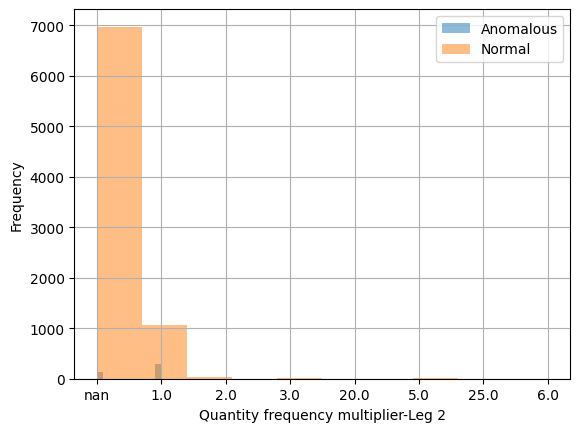

Quantity unit of measure-Leg 1


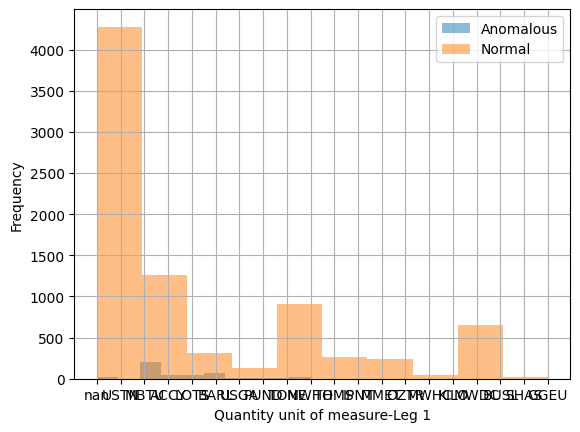

Quantity unit of measure-Leg 2


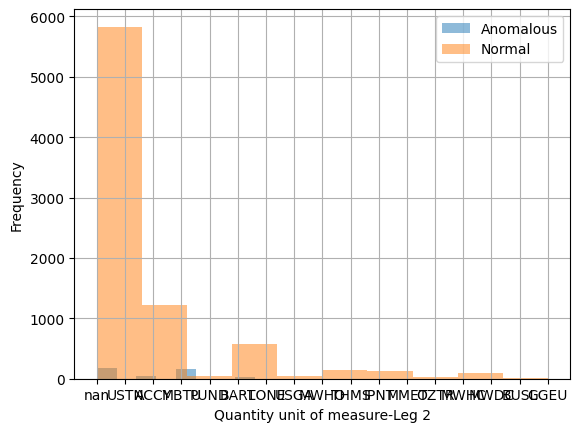

Quantity frequency-Leg 1


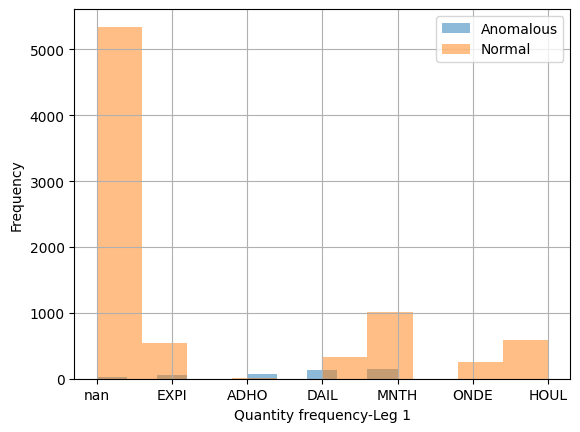

Quantity frequency-Leg 2


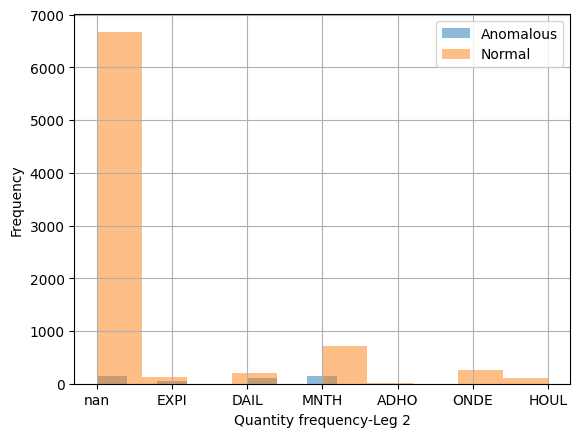

Effective date of the notional amount-Leg 1


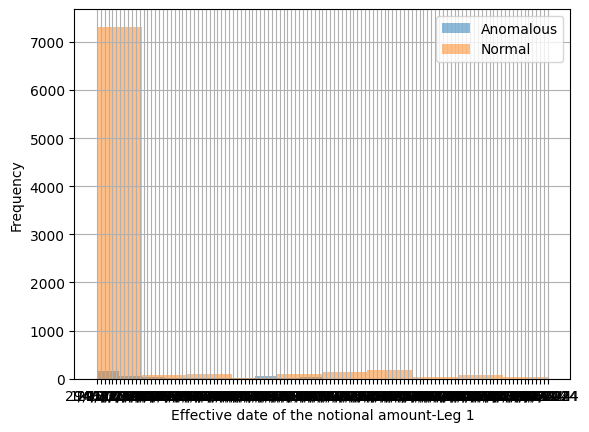

Effective date of the notional amount-Leg 2


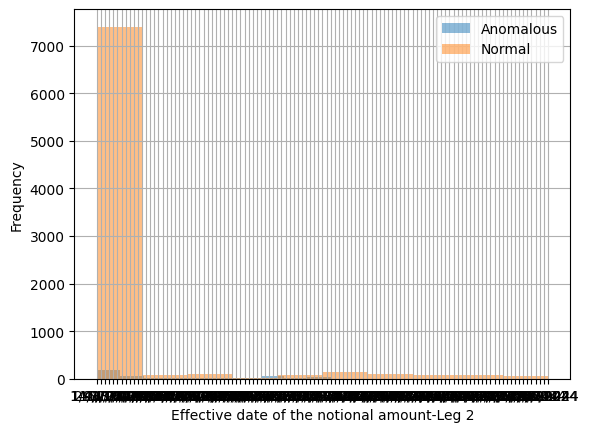

End date of the notional amount-Leg 1


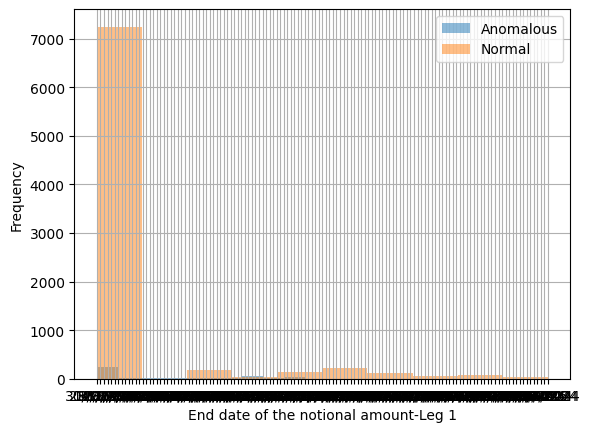

End date of the notional amount-Leg 2


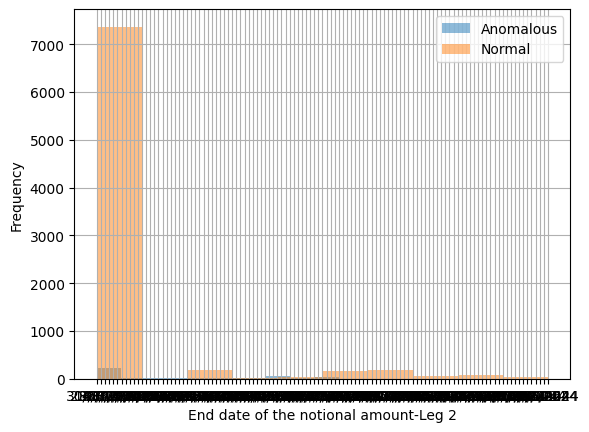

Call amount


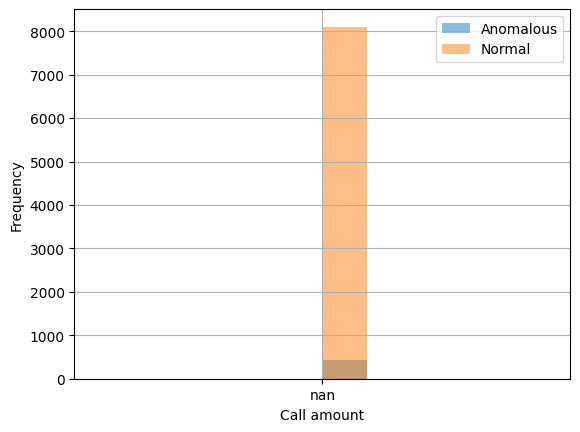

Call currency


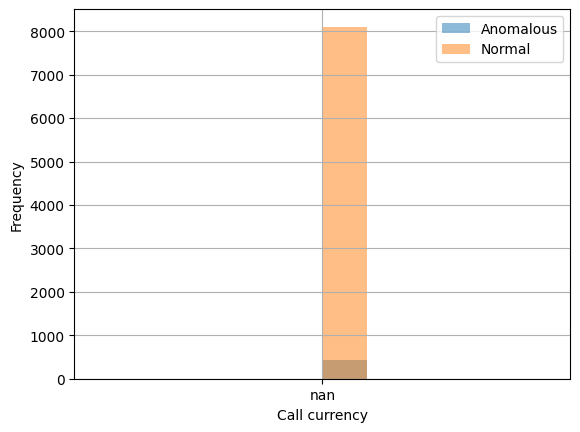

Put amount


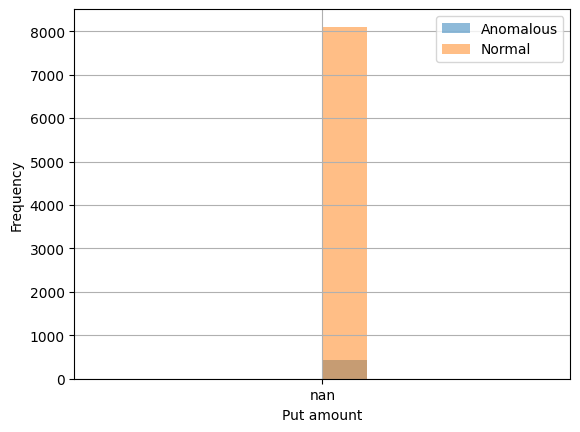

Put currency


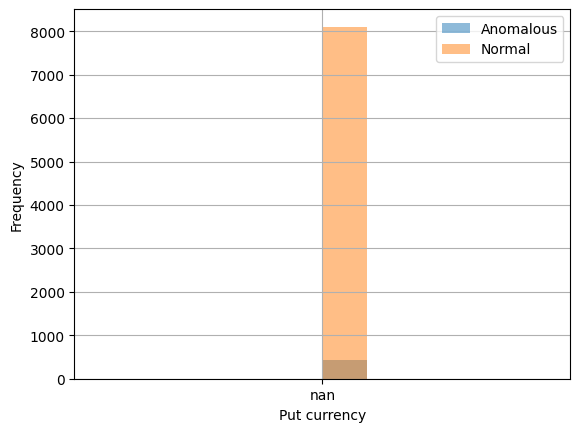

Exchange rate


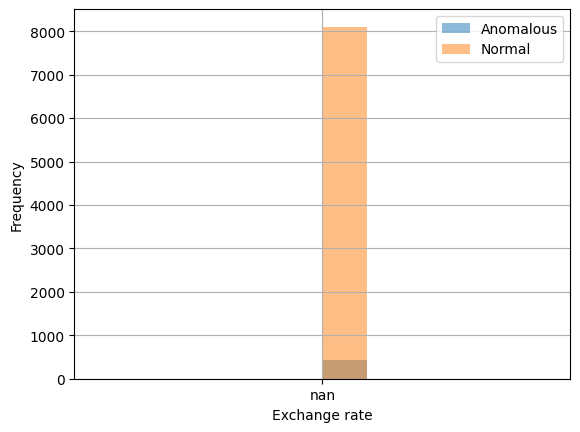

Exchange rate basis


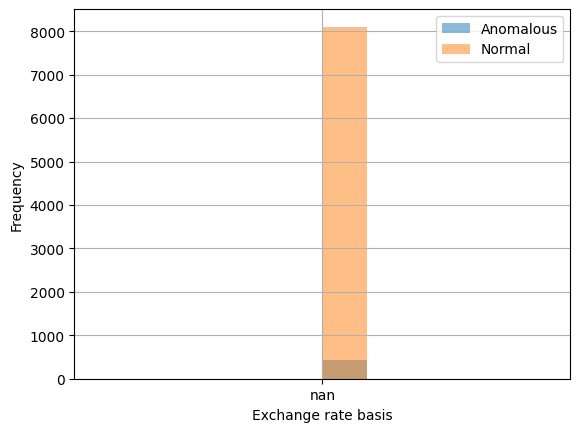

First exercise date


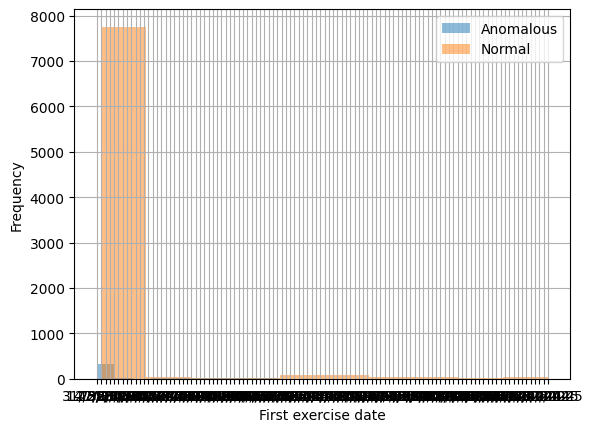

Fixed rate-Leg 1


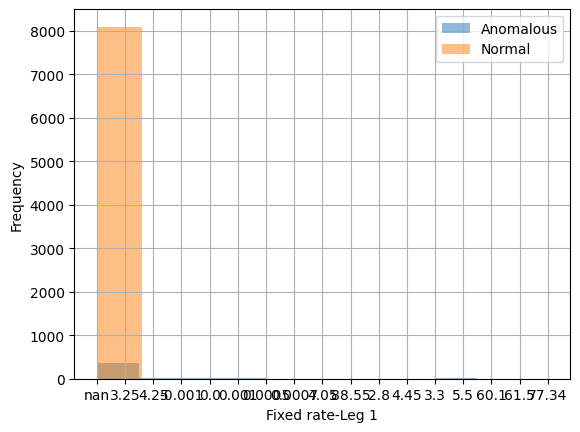

Fixed rate-Leg 2


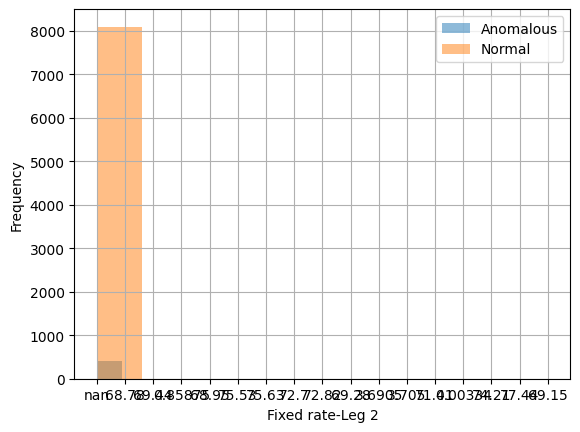

Option Premium Currency


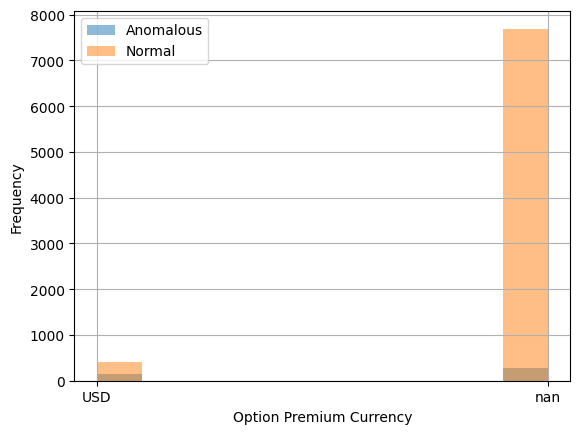

Price unit of measure


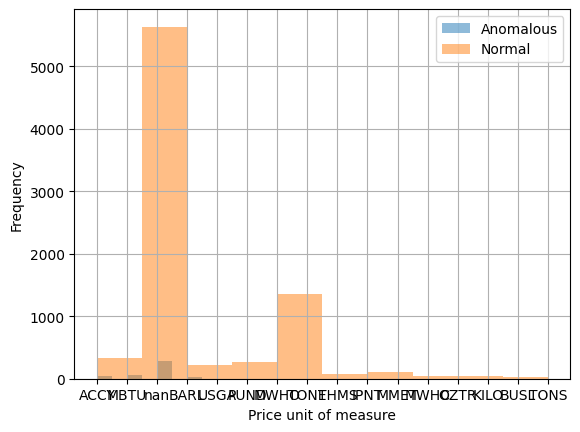

Spread-Leg 2


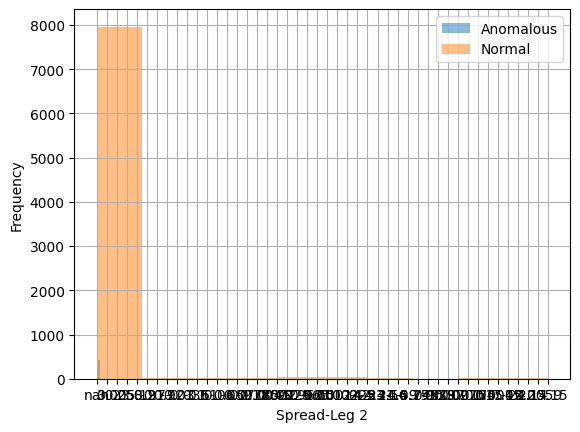

Spread currency-Leg 1


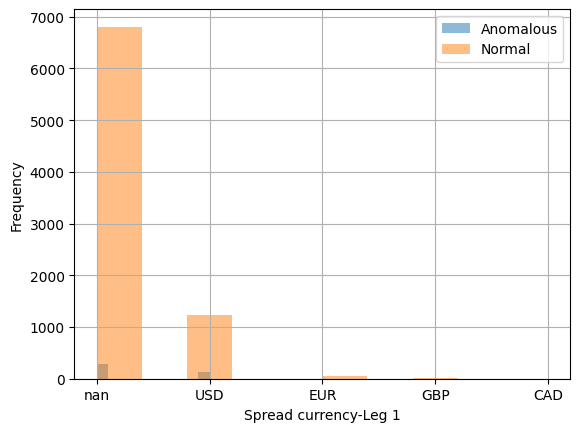

Spread currency-Leg 2


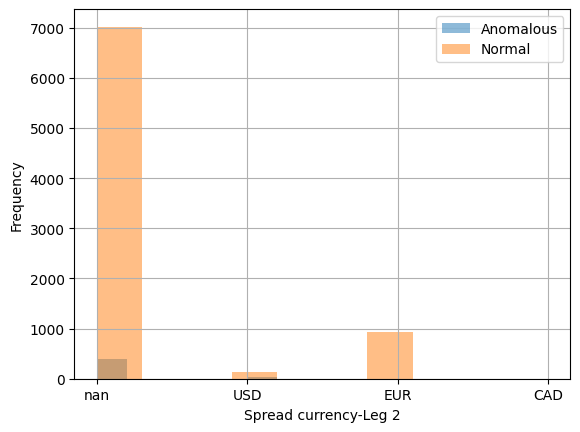

Strike price currency/currency pair


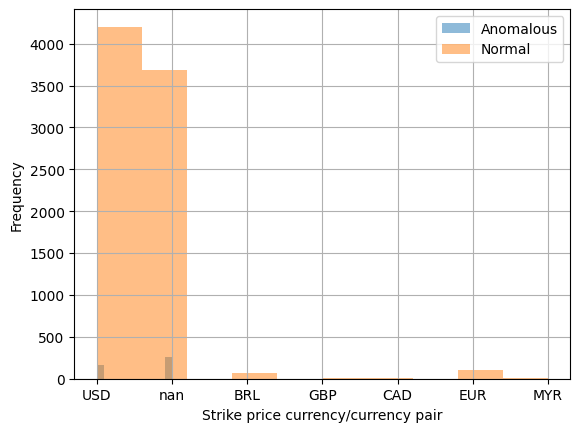

Skipping boolean feature: Post-priced swap indicator
Price currency


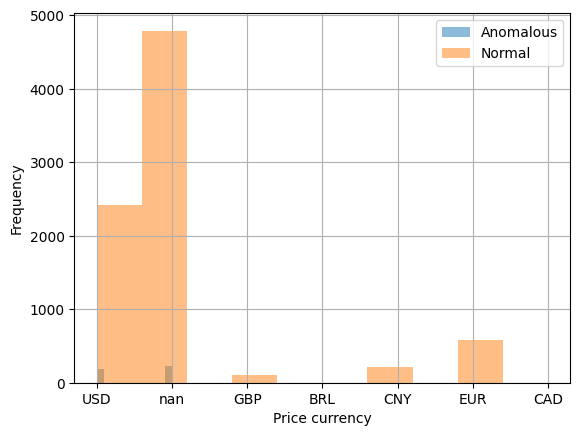

Price notation


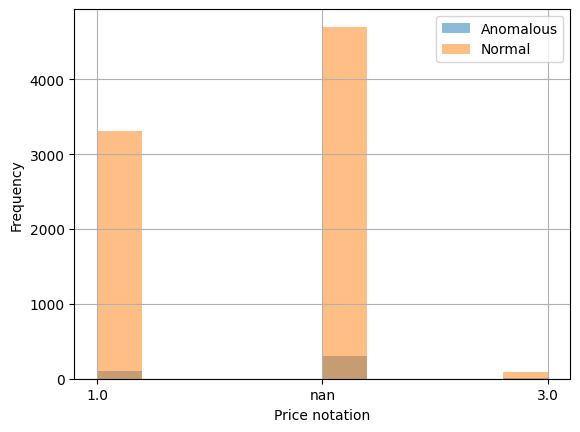

Spread notation-Leg 1


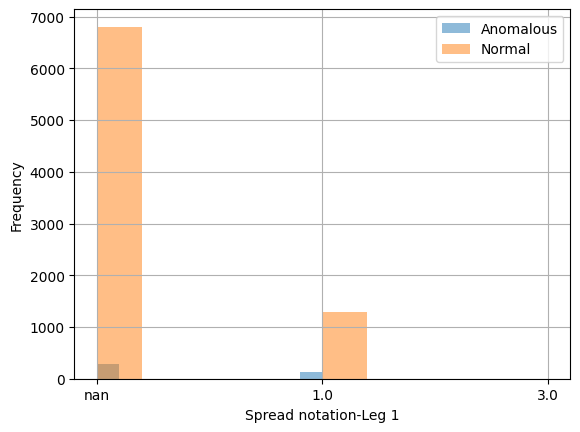

Spread notation-Leg 2


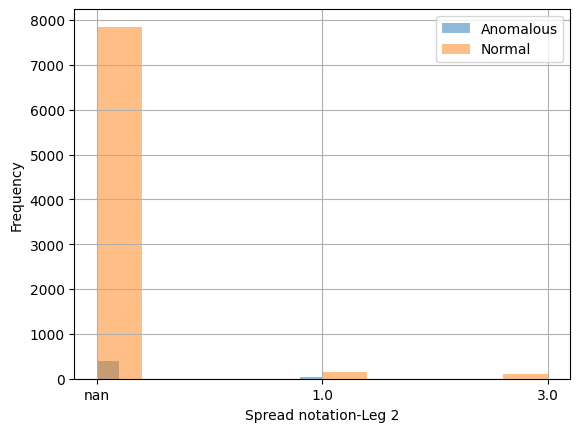

Strike price notation


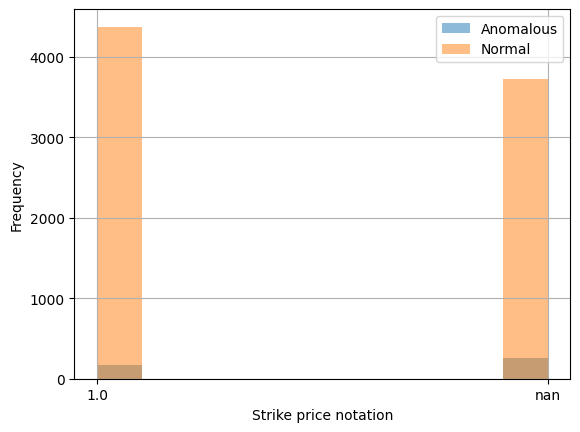

Fixed rate day count convention-leg 1


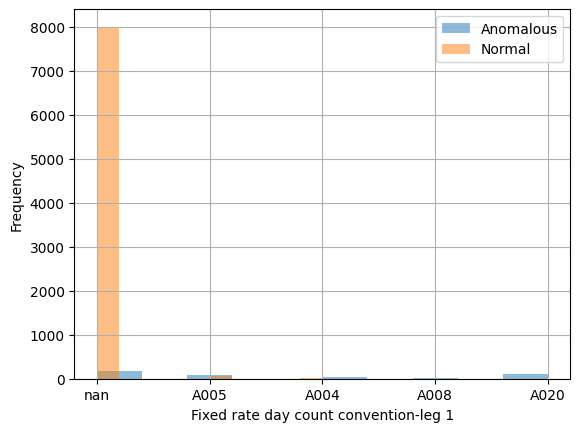

Fixed rate day count convention-leg 2


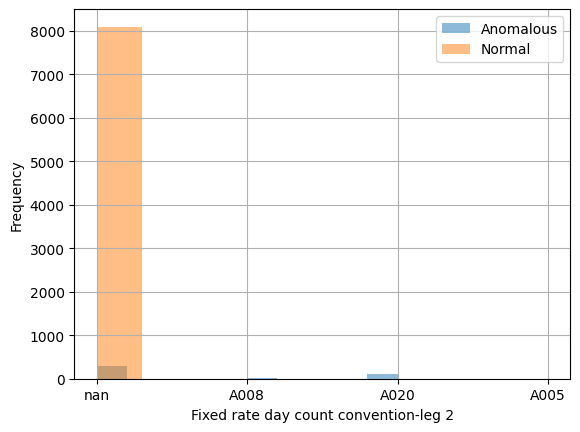

Floating rate day count convention-leg 1


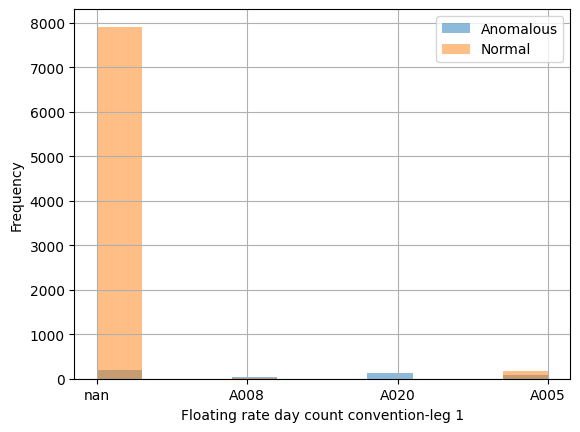

Floating rate day count convention-leg 2


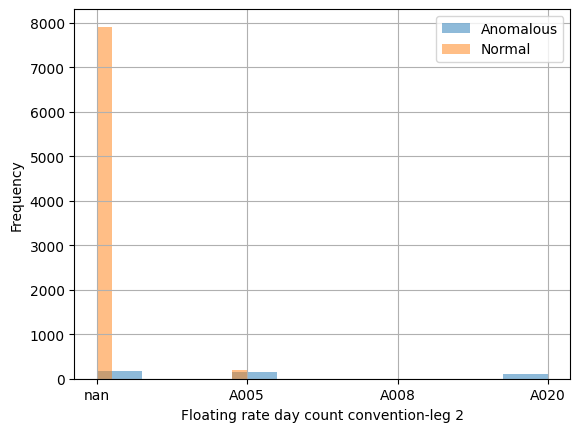

Floating rate reset frequency period-leg 1


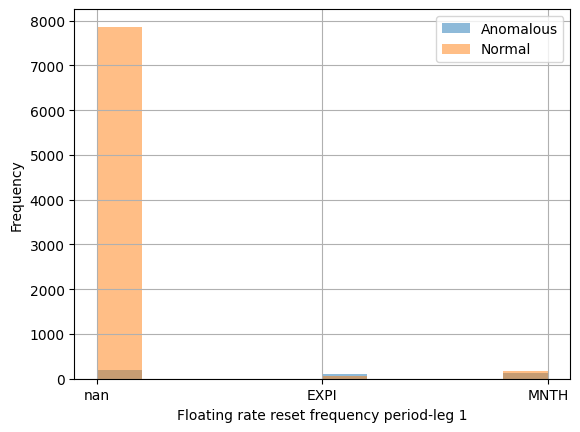

Floating rate reset frequency period-leg 2


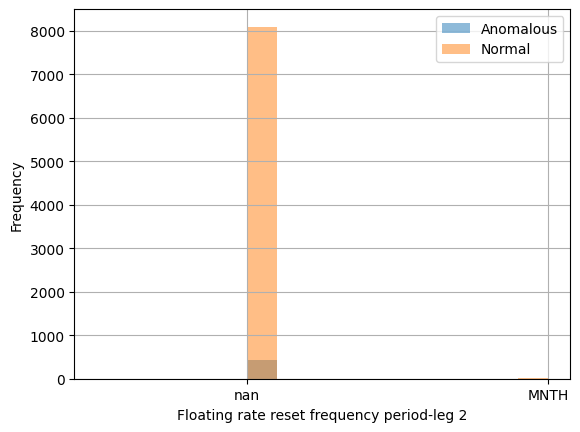

Floating rate reset frequency period multiplier-leg 1


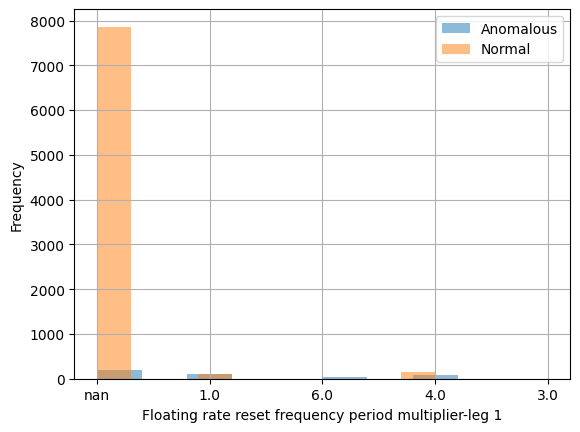

Floating rate reset frequency period multiplier-leg 2


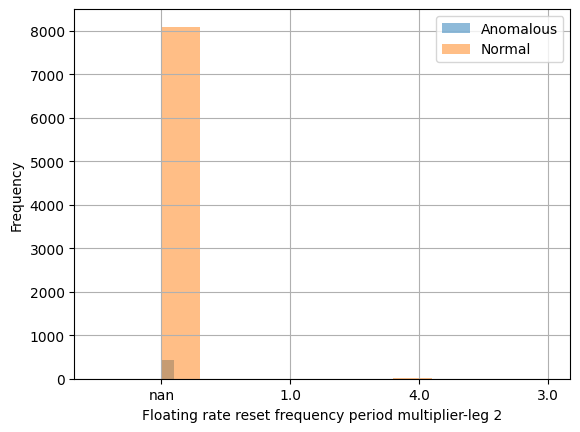

Other payment amount


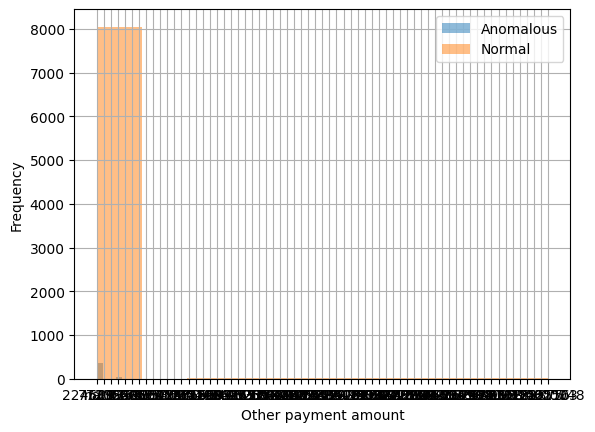

Fixed rate payment frequency period-Leg 1


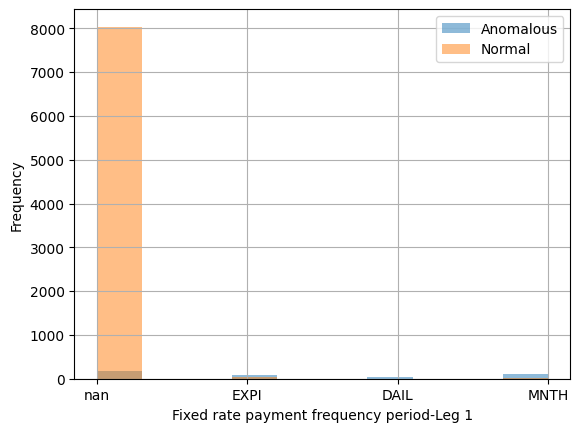

Floating rate payment frequency period-Leg 1


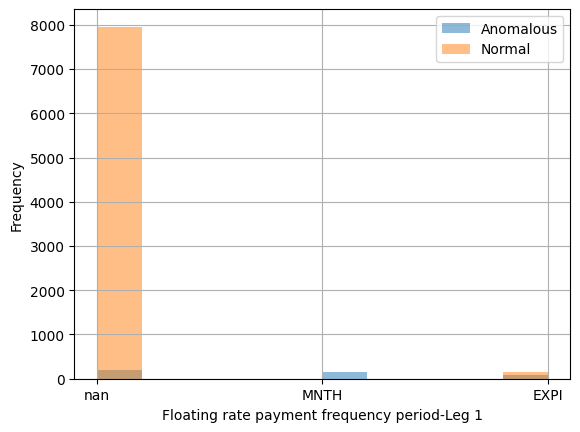

Fixed rate payment frequency period-Leg 2


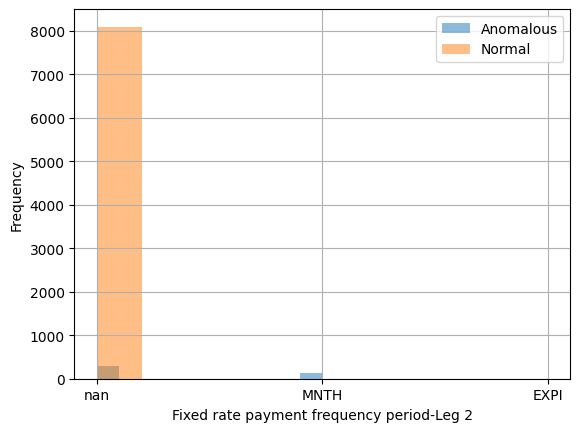

Floating rate payment frequency period-Leg 2


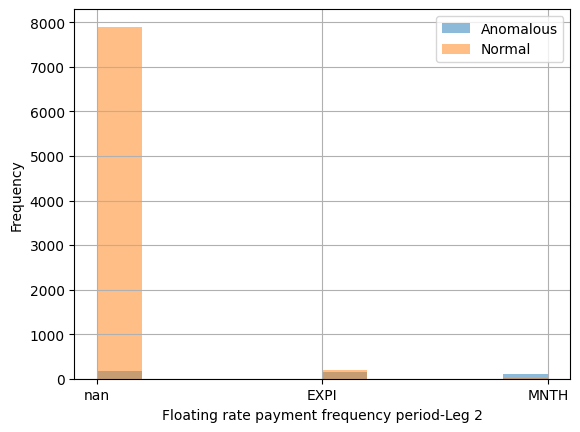

Fixed rate payment frequency period multiplier-Leg 1


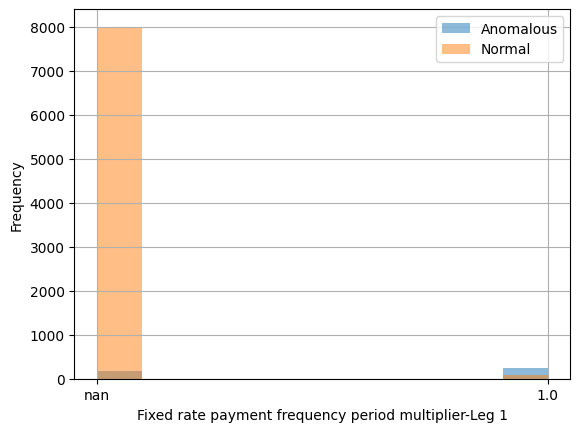

Floating rate payment frequency period multiplier-Leg 1


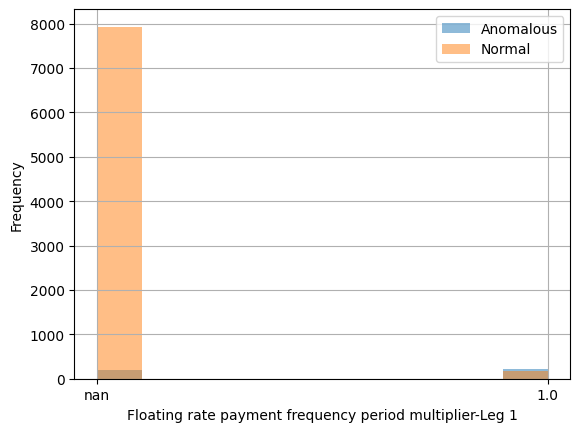

Fixed rate payment frequency period multiplier-Leg 2


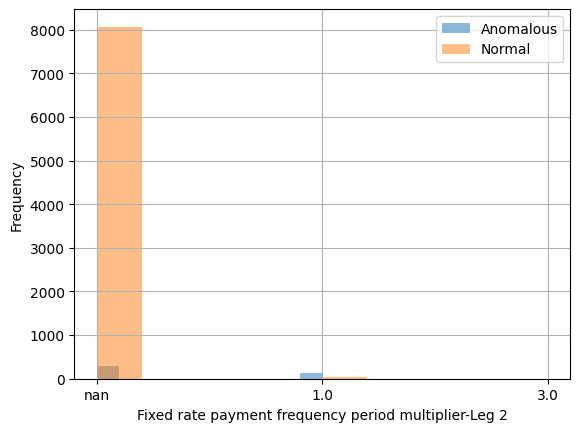

Floating rate payment frequency period multiplier-Leg 2


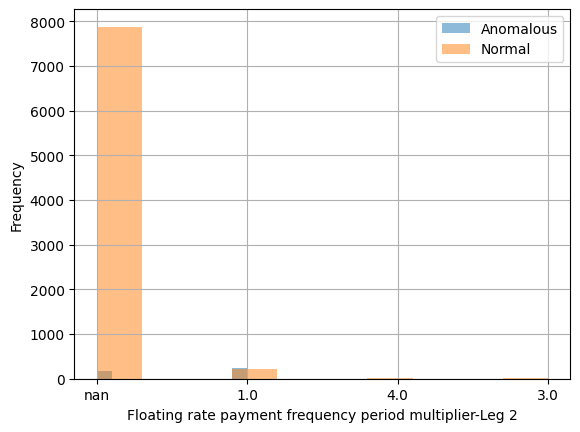

Other payment type


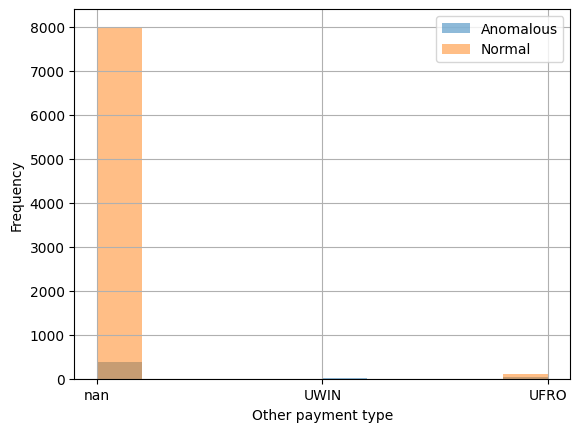

Other payment currency


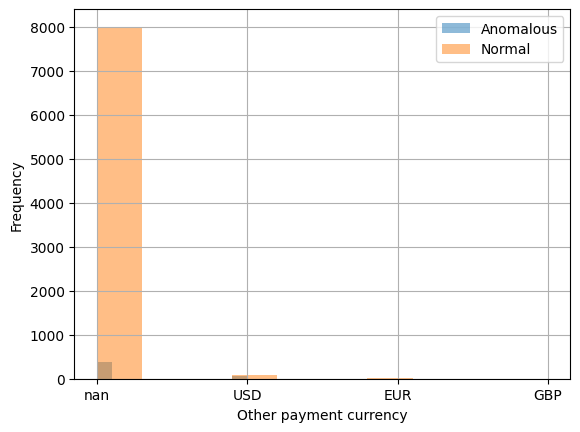

Settlement currency-Leg 1


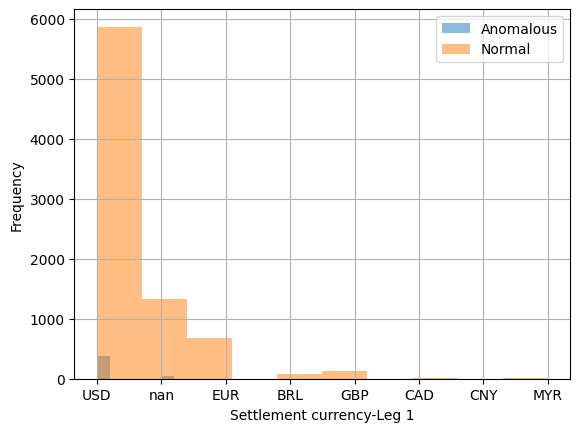

Settlement currency-Leg 2


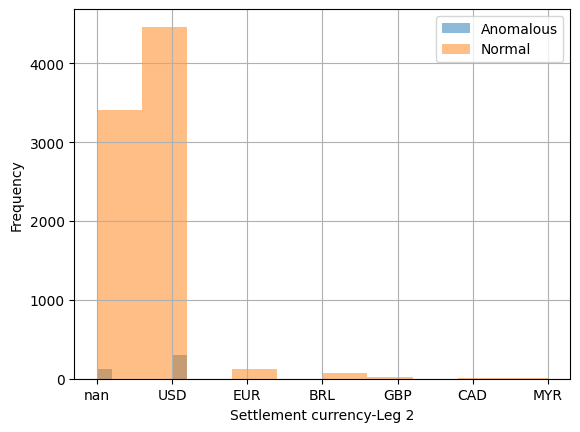

Settlement location


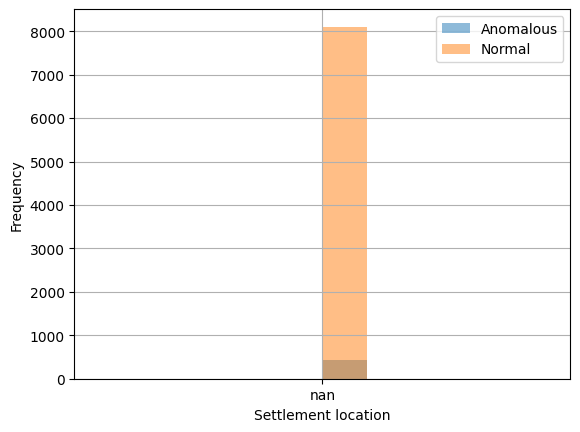

Collateralisation category


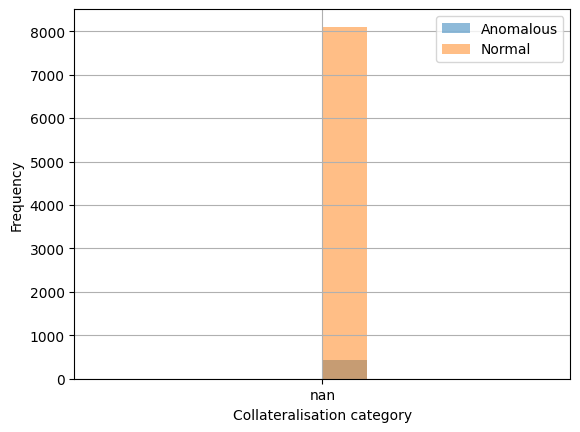

Skipping boolean feature: Custom basket indicator
Index factor


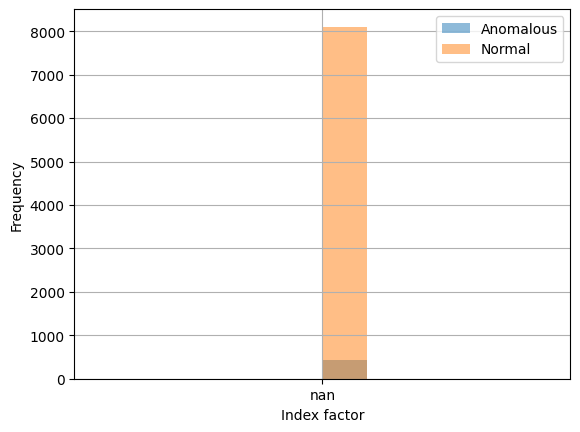

Underlier ID-Leg 1


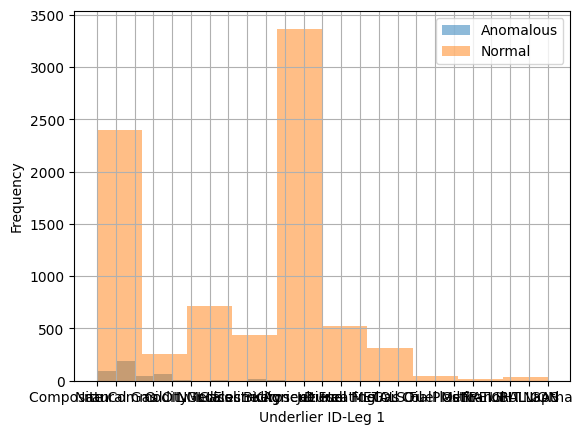

Underlier ID-Leg 2


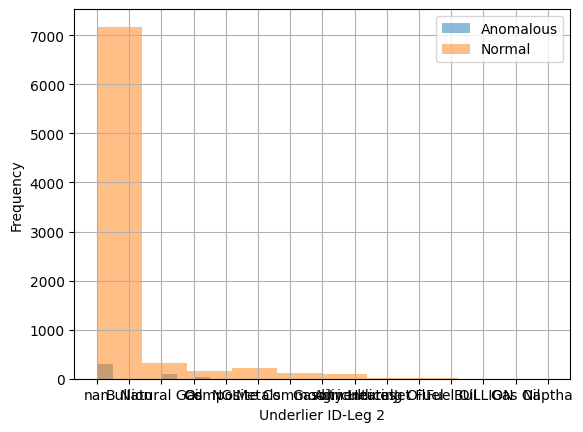

Underlier ID source-Leg 1


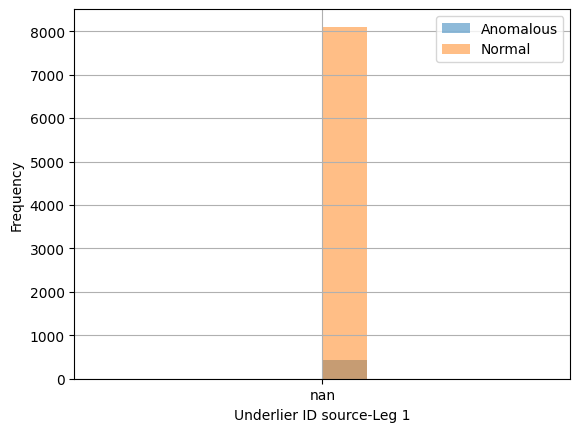

Underlying Asset Name


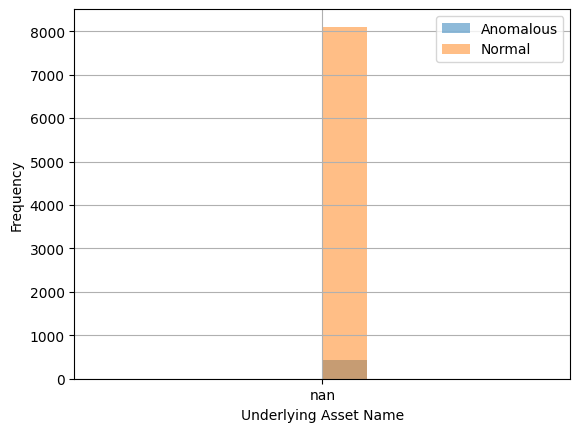

Underlying asset subtype or underlying contract subtype-Leg 1


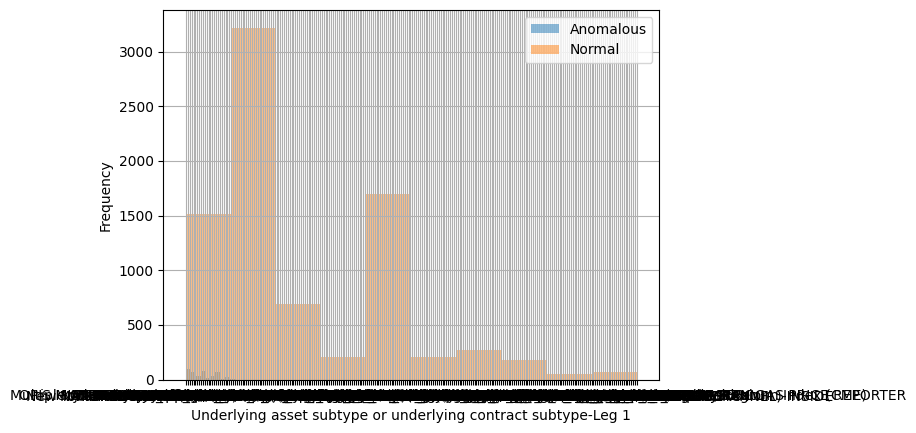

Underlying asset subtype or underlying contract subtype-Leg 2


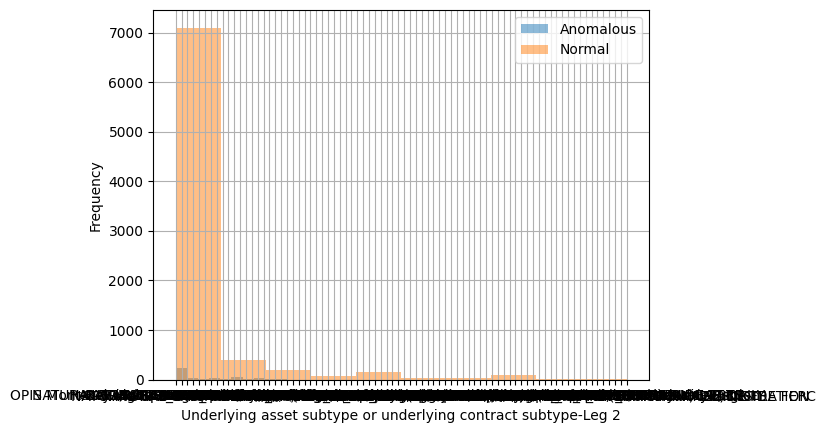

Embedded Option type


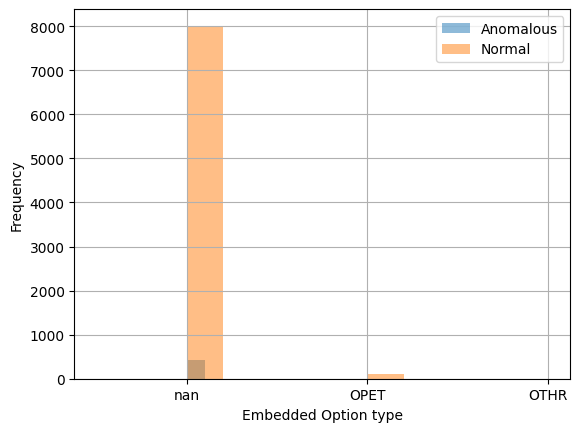

Option Type


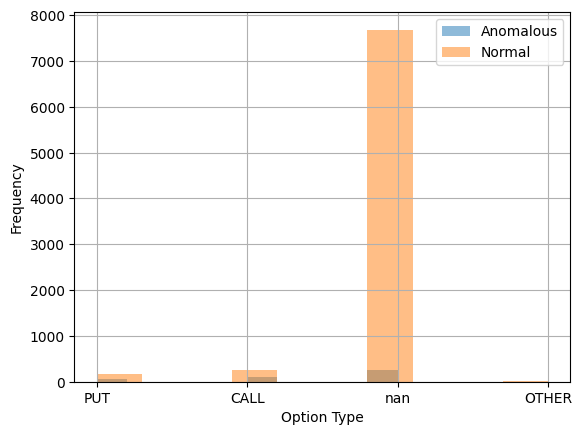

Option Style


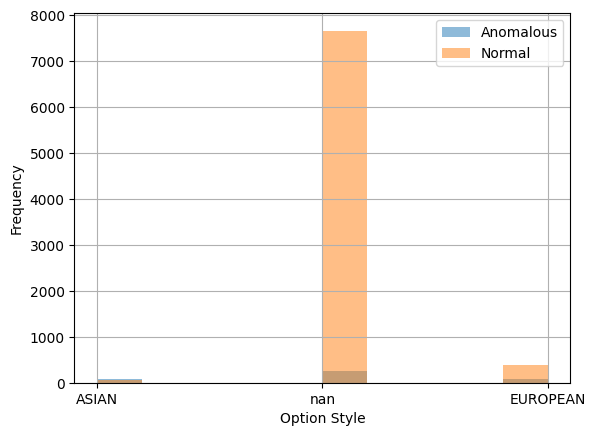

Skipping boolean feature: Package indicator
Package transaction price currency


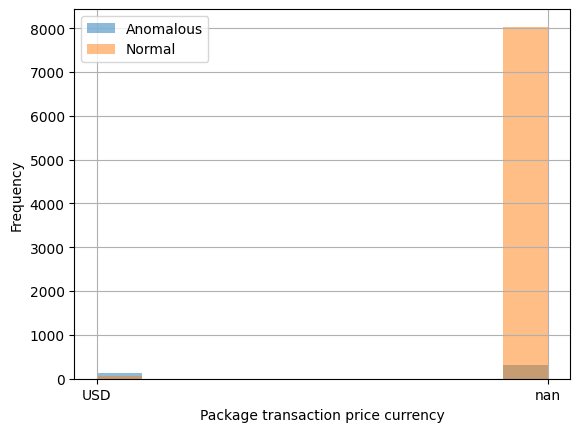

Package transaction price notation


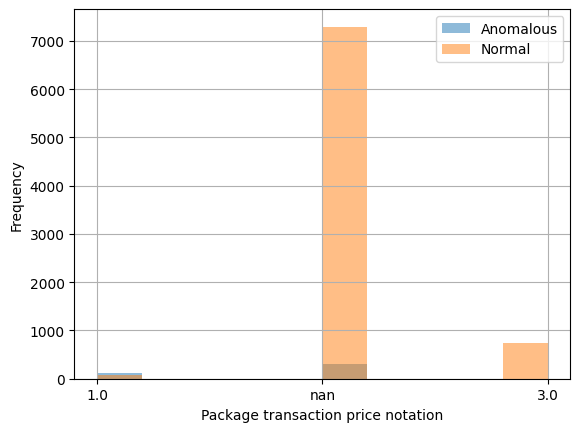

Package transaction spread


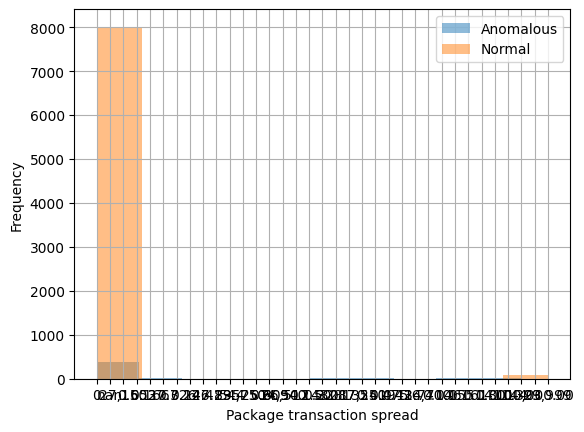

Package transaction spread currency


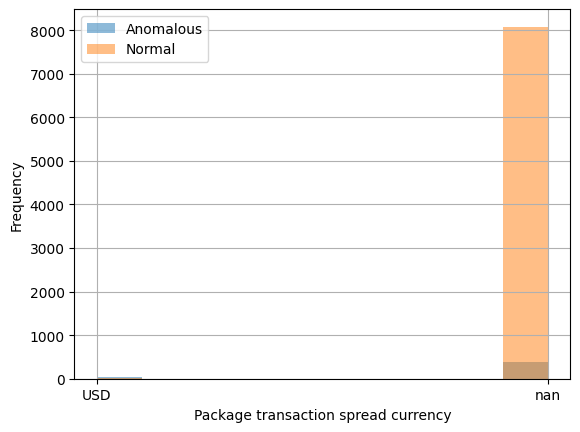

Package transaction spread notation


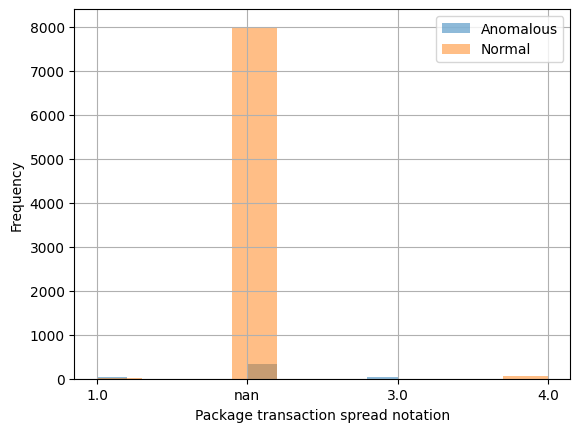

Physical delivery location-Leg 1


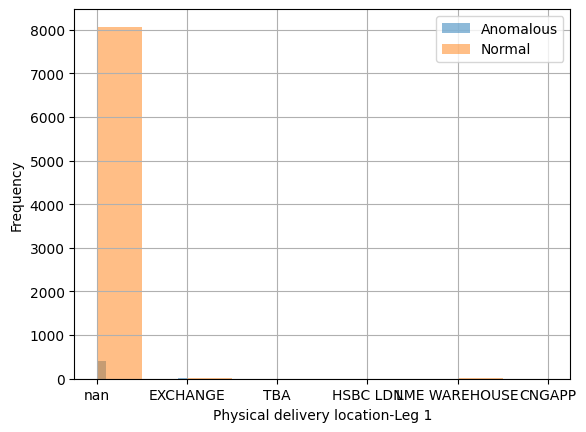

Delivery Type


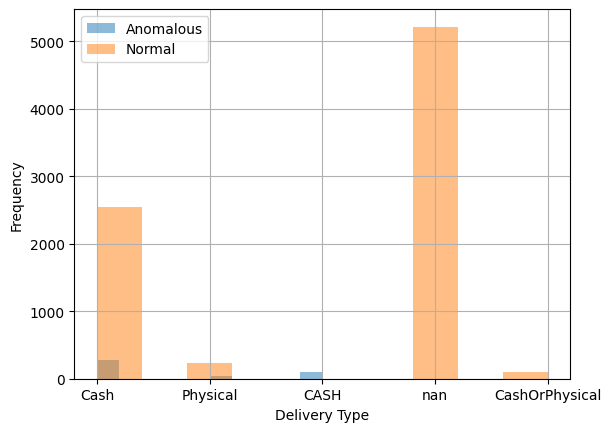

Unique Product Identifier


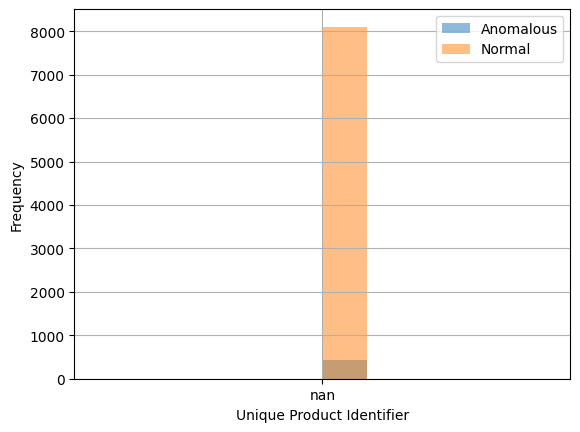

UPI FISN


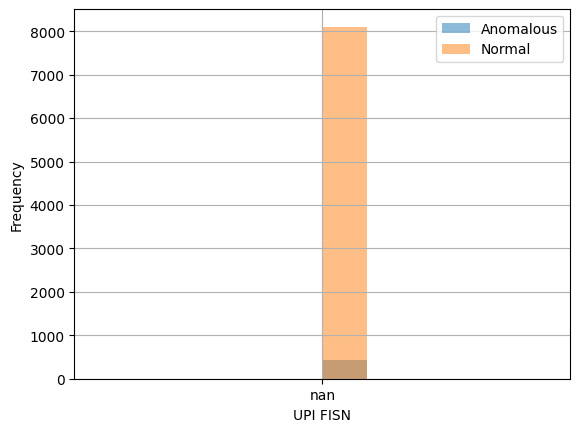

UPI Underlier Name


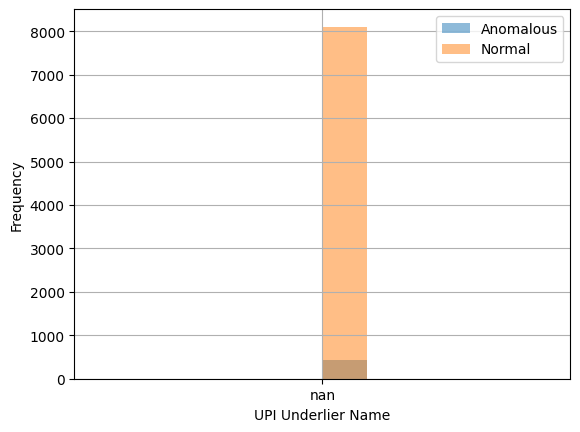

In [ ]:
import matplotlib.pyplot as plt

# Analyze the distribution of anomaly scores
df['anomaly_score'].hist()

# Investigate the features of anomalous records
anomalous_records = dff[dff['anomaly_prediction'] == -1]
print(anomalous_records.describe())

# Compare the features of anomalous records to normal records
normal_records = dff[dff['anomaly_prediction'] == 1]
print(normal_records.describe())

# Visualize the differences in feature distributions
for feature in features:
    if anomalous_records[feature].dtype != 'bool': # Check if the column is boolean
        anomalous_records[feature].astype(str).hist(alpha=0.5, label='Anomalous')
        print(feature)
        normal_records[feature].astype(str).hist(alpha=0.5, label='Normal')

        plt.xlabel(feature)
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()
    else:
        print(f"Skipping boolean feature: {feature}") # Inform the user about skipped columns

# Analyze the context of anomalous records
# Look for patterns or trends in the anomalous records
# For example, are there specific time periods or values of other features that are associated with anomalies?
# You can use grouping and aggregation to explore these relationships

# Consider domain expertise
# Consult with subject matter experts to understand the meaning of the anomalies and their potential causes

In [ ]:
# prompt: can we do another model for anamoly which can  pin point the feature

import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# ... (Your existing code) ...

# Train a Local Outlier Factor (LOF) model
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)  # Adjust parameters as needed
lof.fit_predict(X_scaled)

# Get the outlier scores
lof_scores = lof.negative_outlier_factor_

# Add LOF scores to the DataFrame
df['lof_score'] = lof_scores

# Identify the features contributing to anomalies
# This is a simplified approach, you might need more sophisticated methods
def get_contributing_features(row, X_scaled, lof):
  """
  Identifies features contributing to an anomaly based on LOF.

  Args:
    row: The row of the DataFrame containing the anomaly.
    X_scaled: The scaled feature matrix.
    lof: The trained LocalOutlierFactor model.

  Returns:
    A list of features contributing to the anomaly.
  """
  index = row.name
  neighbors = lof.kneighbors([X_scaled[index]], return_distance=False)
  neighbor_indices = neighbors[0]

  # Calculate the difference between the anomaly and its neighbors
  diff = X_scaled[index] - np.mean(X_scaled[neighbor_indices], axis=0)

  # Identify features with significant differences
  contributing_features = [features[i] for i in range(len(diff)) if abs(diff[i]) > 0.5]  # Adjust threshold as needed
  return contributing_features

# Apply the function to identify contributing features for anomalies
df['contributing_features'] = df.apply(lambda row: get_contributing_features(row, X_scaled, lof), axis=1)

# Print the contributing features for anomalous records
anomalous_records = df[df['lof_score'] < -1]  # Filter for anomalies based on LOF score
print(anomalous_records[['contributing_features']])


     contributing_features
1                       []
2                       []
3                       []
4                       []
6                       []
...                    ...
8524                    []
8525                    []
8526                    []
8528                    []
8529                    []

[5733 rows x 1 columns]


In [ ]:
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# ... (Your existing code) ...

# Train a Local Outlier Factor (LOF) model
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)  # Adjust parameters as needed
# Ensure that X_scaled has the same number of rows as df
X_scaled = X_scaled[:df.shape[0],:]
lof.fit_predict(X_scaled)

# Get the outlier scores
lof_scores = lof.negative_outlier_factor_

# Add LOF scores to the DataFrame
df['lof_score'] = lof_scores

# Identify the features contributing to anomalies
# This is a simplified approach, you might need more sophisticated methods
def get_contributing_features(row, X_scaled, lof):
  """
  Identifies features contributing to an anomaly based on LOF.

  Args:
    row: The row of the DataFrame containing the anomaly.
    X_scaled: The scaled feature matrix.
    lof: The trained LocalOutlierFactor model.

  Returns:
    A list of features contributing to the anomaly.
  """
  print(row)
  print(X_scaled.shape)
  print(lof)
  index = row.name
  neighbors = lof.kneighbors([X_scaled[index]], return_distance=False)
  neighbor_indices = neighbors[0]

    # Calculate the difference between the anomaly and its neighbors
  diff = X_scaled[index] - np.mean(X_scaled[neighbor_indices], axis=0)

    # Identify features with significant differences
  contributing_features = [features[i] for i in range(len(diff)) if abs(diff[i]) > 0.5]  # Adjust threshold as needed
  return contributing_features


# Apply the function to identify contributing features for anomalies
df['contributing_features'] = df.apply(lambda row: get_contributing_features(row, X_scaled, lof), axis=1)

# Print the contributing features for anomalous records
anomalous_records = df[df['lof_score'] < -1]  # Filter for anomalies based on LOF score
print(anomalous_records[['contributing_features']])

Streaming output truncated to the last 5000 lines.
(8530, 92)
LocalOutlierFactor(contamination=0.05)
Dissemination Identifier             932125042
Original Dissemination Identifier          NaN
Action type                                  3
Event type                                   3
Amendment indicator                          0
                                       ...    
UPI Underlier Name_d_isnull                  0
anomaly_prediction                           1
anomaly_score                         0.225315
lof_score                           -41.644838
contributing_features                       []
Name: 8174, Length: 440, dtype: object
(8530, 92)
LocalOutlierFactor(contamination=0.05)
Dissemination Identifier             932125043
Original Dissemination Identifier          NaN
Action type                                  3
Event type                                   3
Amendment indicator                          0
                                       ...    
UPI Underli

In [ ]:
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import shap

# Assuming you have X_scaled and features defined

# Train a Local Outlier Factor (LOF) model
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
lof.fit_predict(X_scaled)

# Get the outlier scores
lof_scores = lof.negative_outlier_factor_

# Add LOF scores to the DataFrame
df['lof_score'] = lof_scores

# Identify the features contributing to anomalies using SHAP

# Create a SHAP explainer for LOF (using KernelExplainer for model-agnostic explanations)
explainer = shap.KernelExplainer(lof.decision_function, X_scaled)

# Calculate SHAP values for anomalous records
anomalous_records = df[df['lof_score'] < -1]
shap_values = explainer.shap_values(X_scaled[anomalous_records.index])

# Add SHAP values to the DataFrame
df.loc[anomalous_records.index, 'shap_values'] = shap_values.tolist()

# Function to get contributing features based on SHAP values
def get_contributing_features_shap(row, features):
  """
  Identifies features contributing to an anomaly based on SHAP values.

  Args:
    row: The row of the DataFrame containing the anomaly.
    features: The list of feature names.

  Returns:
    A list of features contributing to the anomaly.
  """
  if isinstance(row['shap_values'], list):
    shap_vals = np.array(row['shap_values'])
    # Get indices of features with high absolute SHAP values
    important_features_idx = np.argsort(np.abs(shap_vals))[::-1]
    # Return the names of the top contributing features
    return [features[i] for i in important_features_idx]
  else:
    return []

# Apply the function to get contributing features
df['contributing_features_shap'] = df.apply(lambda row: get_contributing_features_shap(row, features), axis=1)

# Print the contributing features for anomalous records
print(anomalous_records[['contributing_features_shap']])

# You can further visualize the SHAP values for individual anomalies
# For example, using shap.force_plot or shap.summary_plot

AttributeError: decision_function is not available when novelty=False. Use novelty=True if you want to use LOF for novelty detection and compute decision_function for new unseen data. Note that the opposite LOF of the training samples is always available by considering the negative_outlier_factor_ attribute.

In [ ]:
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import shap

# Assuming you have X_scaled and features defined

# Train a Local Outlier Factor (LOF) model with novelty=True
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05, novelty=True) # Set novelty to True
lof.fit(X_scaled) # Fit the model with the training data

# Get the outlier scores
lof_scores = lof.negative_outlier_factor_

# Add LOF scores to the DataFrame
df['lof_score'] = lof_scores

# Identify the features contributing to anomalies using SHAP

# Create a SHAP explainer for LOF (using KernelExplainer for model-agnostic explanations)
explainer = shap.KernelExplainer(lof.decision_function, X_scaled) # Now decision_function is available

# Calculate SHAP values for anomalous records
anomalous_records = df[df['lof_score'] < -1]
shap_values = explainer.shap_values(X_scaled[anomalous_records.index])

# Add SHAP values to the DataFrame
df.loc[anomalous_records.index, 'shap_values'] = shap_values.tolist()

# Function to get contributing features based on SHAP values
def get_contributing_features_shap(row, features):
  """
  Identifies features contributing to an anomaly based on SHAP values.

  Args:
    row: The row of the DataFrame containing the anomaly.
    features: The list of feature names.

  Returns:
    A list of features contributing to the anomaly.
  """
  if isinstance(row['shap_values'], list):
    shap_vals = np.array(row['shap_values'])
    # Get indices of features with high absolute SHAP values
    important_features_idx = np.argsort(np.abs(shap_vals))[::-1]
    # Return the names of the top contributing features
    return [features[i] for i in important_features_idx]
  else:
    return []

# Apply the function to get contributing features
df['contributing_features_shap'] = df.apply(lambda row: get_contributing_features_shap(row, features), axis=1)

# Print the contributing features for anomalous records
print(anomalous_records[['contributing_features_shap']])

# You can further visualize the SHAP values for individual anomalies
# For example, using shap.force_plot or shap.summary_plot

  0%|          | 0/5733 [00:00<?, ?it/s]

In [ ]:
ar =pd.DataFrame(anomalous_records[['contributing_features']])


In [ ]:
ar["contributing_features"].value_counts()

,count
contributing_features,
[],5294
[Amendment indicator],54
[Action type],38
[Underlying asset subtype or underlying contract subtype-Leg 2],18
[Event type],16
...,...
[Underlying Asset Name],1
"[Spread-Leg 2, Underlier ID-Leg 1]",1
"[Maturity date of the underlier, Fixed rate-Leg 2, Strike price currency/currency pair]",1


In [ ]:
!pip install shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 3.7 MB/s eta 0:00:00


In [ ]:
# prompt: can we do an autoencoder for this data to detect anamoly, I already categorise my columns , in cat_col where type =Cat are category columns which I want to encode , for dates we will chnage them to integrer and rest are numeric already

import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from sklearn.impute import SimpleImputer

col_cat = col_cat[~col_cat['Column'].str.endswith('_d_isnull')]
col_cat = col_cat[~col_cat['Column'].str.endswith('_d_length')]
col_cat = col_cat[~col_cat['Column'].str.endswith('_dtype')]

# Separate categorical and numerical columns
cat_cols = col_cat[col_cat['Type'] == 'Cat']['Column'].tolist()
date_cols = col_cat[col_cat['Type'] == 'Date']['Column'].tolist()
num_cols = [col for col in dff.columns if col not in cat_cols + date_cols]


# Encode categorical features
for col in cat_cols:
  le = LabelEncoder()
  dff[col] = le.fit_transform(dff[col])

# Convert date columns to integers (assuming they are in a suitable format)
date_columns=col_cat[col_cat['Type']=='Date']['Column']
#date_columns = df.select_dtypes(include=['datetime']).columns
for column in date_columns:
  print(column)
  try:
    dff[column] = pd.to_datetime(dff[column], errors='coerce').astype('int64') // 10**9
  except ValueError:
    # If the initial conversion fails, try different date formats
    for fmt in ['%Y-%m-%d %H:%M:%S', '%m/%d/%Y %H:%M:%S', '%Y-%m-%d','%Y-%m-%dT%H:%M:%SZ']:
      try:
        dff[column] = pd.to_datetime(dff[column], format=fmt, errors='coerce').astype('int64') // 10**9
        break
      except ValueError:
        pass
    else:
      print(f"Warning: Could not convert column '{column}' to numeric timestamp.")



# Scale numerical features
scaler = MinMaxScaler()
dff[num_cols] = scaler.fit_transform(dff[num_cols])

# Define the autoencoder model
input_dim = dff.shape[1]
encoding_dim = 10  # Adjust this value based on your data

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Fit the autoencoder
autoencoder.fit(dff, dff, epochs=100, batch_size=32, shuffle=True)  # Adjust epochs and batch_size as needed

# Get the encoded and decoded output
encoded_data = autoencoder.predict(dff)

# Calculate reconstruction error (anomaly score)
reconstruction_error =  ((dff - encoded_data) ** 2).mean(axis=1)

# Analyze the reconstruction error to identify anomalies
# (e.g., set a threshold and flag data points with high error)


Event timestamp
Execution Timestamp
Effective Date
Expiration Date
Maturity date of the underlier
Effective date of the notional amount-Leg 1
Effective date of the notional amount-Leg 2
End date of the notional amount-Leg 1
End date of the notional amount-Leg 2
First exercise date
Epoch 1/100


<ipython-input-68-7523dfe61952>:32: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  dff[column] = pd.to_datetime(dff[column], errors='coerce').astype('int64') // 10**9
<ipython-input-68-7523dfe61952>:32: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  dff[column] = pd.to_datetime(dff[column], errors='coerce').astype('int64') // 10**9
<ipython-input-68-7523dfe61952>:32: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  dff[column] = pd.to_datetime(dff[column], errors='coerce').astype('int64') // 10**9
<ipython-input-68-7523dfe61952>:32: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True`

267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: nan
Epoch 2/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan
Epoch 3/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan
Epoch 4/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan
Epoch 5/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan
Epoch 6/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: nan
Epoch 7/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan
Epoch 8/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan
Epoch 9/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: nan
Epoch 10/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: nan
Epoch 11/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: nan
Epoch 12/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: nan
Epoch 13/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: nan
Epoch 14/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan
Epoch 15/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: nan
Epoch 16/100
267/267 ━━━━━━━━━━

In [ ]:
# prompt: why all predicted values are nan in encoded_data, is there some issue with model

# Check the data types of your input data.
print(dff.dtypes)

# Check for missing values.
print(dff.isnull().sum())

# Ensure your data is in a suitable format for the autoencoder.
#  -  Scale your data:  The MinMaxScaler you're using is a good start, but make sure it's applied correctly and handles missing values appropriately.
#  -  Handle categorical variables: If you have categorical variables, you might need to one-hot encode them or use embedding layers in your autoencoder.

# Adjust the autoencoder architecture:
#  -  Try different activation functions (e.g., sigmoid, tanh).
#  -  Experiment with different numbers of layers and neurons in the encoder and decoder.
#  -  Consider adding dropout layers to prevent overfitting.
#  -  Adjust the loss function:  'mean_squared_error' might not be the best choice for all datasets.

# Increase the number of epochs or adjust the batch size.

# Debug the model:
#  -  Print the shapes of the input and output tensors at each layer to ensure the data is flowing correctly.
#  -  Use TensorFlow's debugging tools to identify any issues with the model's training process.

# Example of how to adjust the autoencoder architecture:
input_dim = dff.shape[1]
encoding_dim = 10  # Adjust this value based on your data

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_layer)
# Add more layers if needed
# encoded = Dense(5, activation='relu')(encoded)
decoded = Dense(encoding_dim, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Fit the autoencoder
autoencoder.fit(dff, dff, epochs=100, batch_size=32, shuffle=True)  # Adjust epochs and batch_size as needed

# Get the encoded and decoded output
encoded_data = autoencoder.predict(dff)

# Calculate reconstruction error (anomaly score)
reconstruction_error =  ((dff - encoded_data) ** 2).mean(axis=1)

# Analyze the reconstruction error to identify anomalies
# (e.g., set a threshold and flag data points with high error)


Dissemination Identifier             float64
Original Dissemination Identifier    float64
Action type                            int64
Event type                             int64
Event timestamp                        int64
                                      ...   
Physical delivery location-Leg 1       int64
Delivery Type                          int64
Unique Product Identifier              int64
UPI FISN                               int64
UPI Underlier Name                     int64
Length: 110, dtype: object
Dissemination Identifier                0
Original Dissemination Identifier    6683
Action type                             0
Event type                              0
Event timestamp                         0
                                     ... 
Physical delivery location-Leg 1        0
Delivery Type                           0
Unique Product Identifier               0
UPI FISN                                0
UPI Underlier Name                      0
Length: 110, dty

In [ ]:
reconstruction_error

,0
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
8525,NaN
8526,NaN
8527,NaN
8528,NaN
